Import libs

In [1]:
import xarray
import matplotlib.pyplot as plt
import numpy as np
import datetime
import cv2
from tqdm import tqdm
from scipy.interpolate import NearestNDInterpolator
%matplotlib inline

Read data

In [2]:
input_path = r"/home/fberanek/Desktop/projects/hackathons/cassini/CassiniHackathon.Data/input_data/sar/antakya.nc"
ds = xarray.load_dataset(input_path)

# Convert xarray DataSet to a (bands, t, x, y) DataArray
data = ds[["VV", "VH"]].to_array(dim="bands")

In [5]:
data

<xarray.DataArray (bands: 2, t: 8, y: 73, x: 103)> Size: 481kB
array([[[[ -5.918093  ,  -5.77462   ,  -7.0342045 , ...,  -4.461971  ,
           -4.3292465 ,  -4.3890433 ],
         [ -6.079926  ,  -4.9366684 ,  -5.5147142 , ...,  -2.1322038 ,
           -2.4406965 ,  -4.1683736 ],
         [ -6.9503365 ,  -4.809742  ,  -4.601416  , ...,   0.269916  ,
            0.2052224 ,  -3.1659472 ],
         ...,
         [ -7.737362  ,  -7.271346  ,  -6.022317  , ...,  -8.893839  ,
           -8.166928  ,  -8.172625  ],
         [ -8.867973  ,  -6.8844843 ,  -6.5206194 , ..., -10.523436  ,
          -10.313623  , -11.314263  ],
         [ -8.900856  ,  -6.739158  ,  -9.289848  , ...,  -5.3531637 ,
           -9.923459  , -10.360736  ]],

        [[ -6.7178097 ,  -8.693817  ,  -6.7002335 , ...,  -9.177494  ,
           -7.622034  ,  -6.6270714 ],
         [ -6.4292026 ,  -6.8298283 ,  -4.759805  , ...,  -6.725259  ,
           -4.789933  ,  -4.7426453 ],
         [ -7.001178  ,  -5.356058  ,  -3.461409  , ...,  -2.995299  ,
           -0.86975694,  -3.0429385 ],
...
         [-16.629976  , -14.821176  , -10.702348  , ...,  -9.930288  ,
          -14.340386  , -16.220896  ],
         [-16.622955  , -15.727484  , -11.687948  , ..., -10.523019  ,
          -15.013569  , -17.50285   ],
         [-13.50421   , -13.563513  , -13.428629  , ..., -14.283571  ,
          -18.144726  , -18.963093  ]],

        [[ -8.286162  ,  -9.278666  , -11.286688  , ..., -13.074387  ,
          -12.377524  , -11.83147   ],
         [ -7.3843646 ,  -7.2249722 ,  -8.39525   , ...,  -9.721228  ,
           -9.523183  , -10.281514  ],
         [ -9.869961  ,  -9.002834  ,  -9.404505  , ...,  -5.6641846 ,
           -6.1679144 ,  -8.606531  ],
         ...,
         [-11.229325  , -11.799227  , -11.542963  , ..., -17.379173  ,
          -17.64215   , -15.6520195 ],
         [-14.954358  , -13.730516  , -12.10278   , ..., -13.759924  ,
          -15.203052  , -15.037894  ],
         [-12.6470375 , -11.412546  , -12.764441  , ..., -11.84154   ,
          -14.012227  , -15.151395  ]]]], dtype=float32)
Coordinates:
  * t        (t) datetime64[ns] 64B 2022-12-11 2022-12-23 ... 2023-03-05
  * x        (x) float64 824B 2.436e+05 2.437e+05 ... 2.447e+05 2.447e+05
  * y        (y) float64 584B 4.011e+06 4.011e+06 ... 4.01e+06 4.01e+06
  * bands    (bands) object 16B 'VV' 'VH'
Attributes:
    Conventions:  CF-1.9
    institution:  openEO platform - Geotrellis backend: 0.50.1a1
    description:  
    title:

In [3]:
data[{"t":0, "bands":0}].shape

(73, 103)

Vizulize one sample from each band

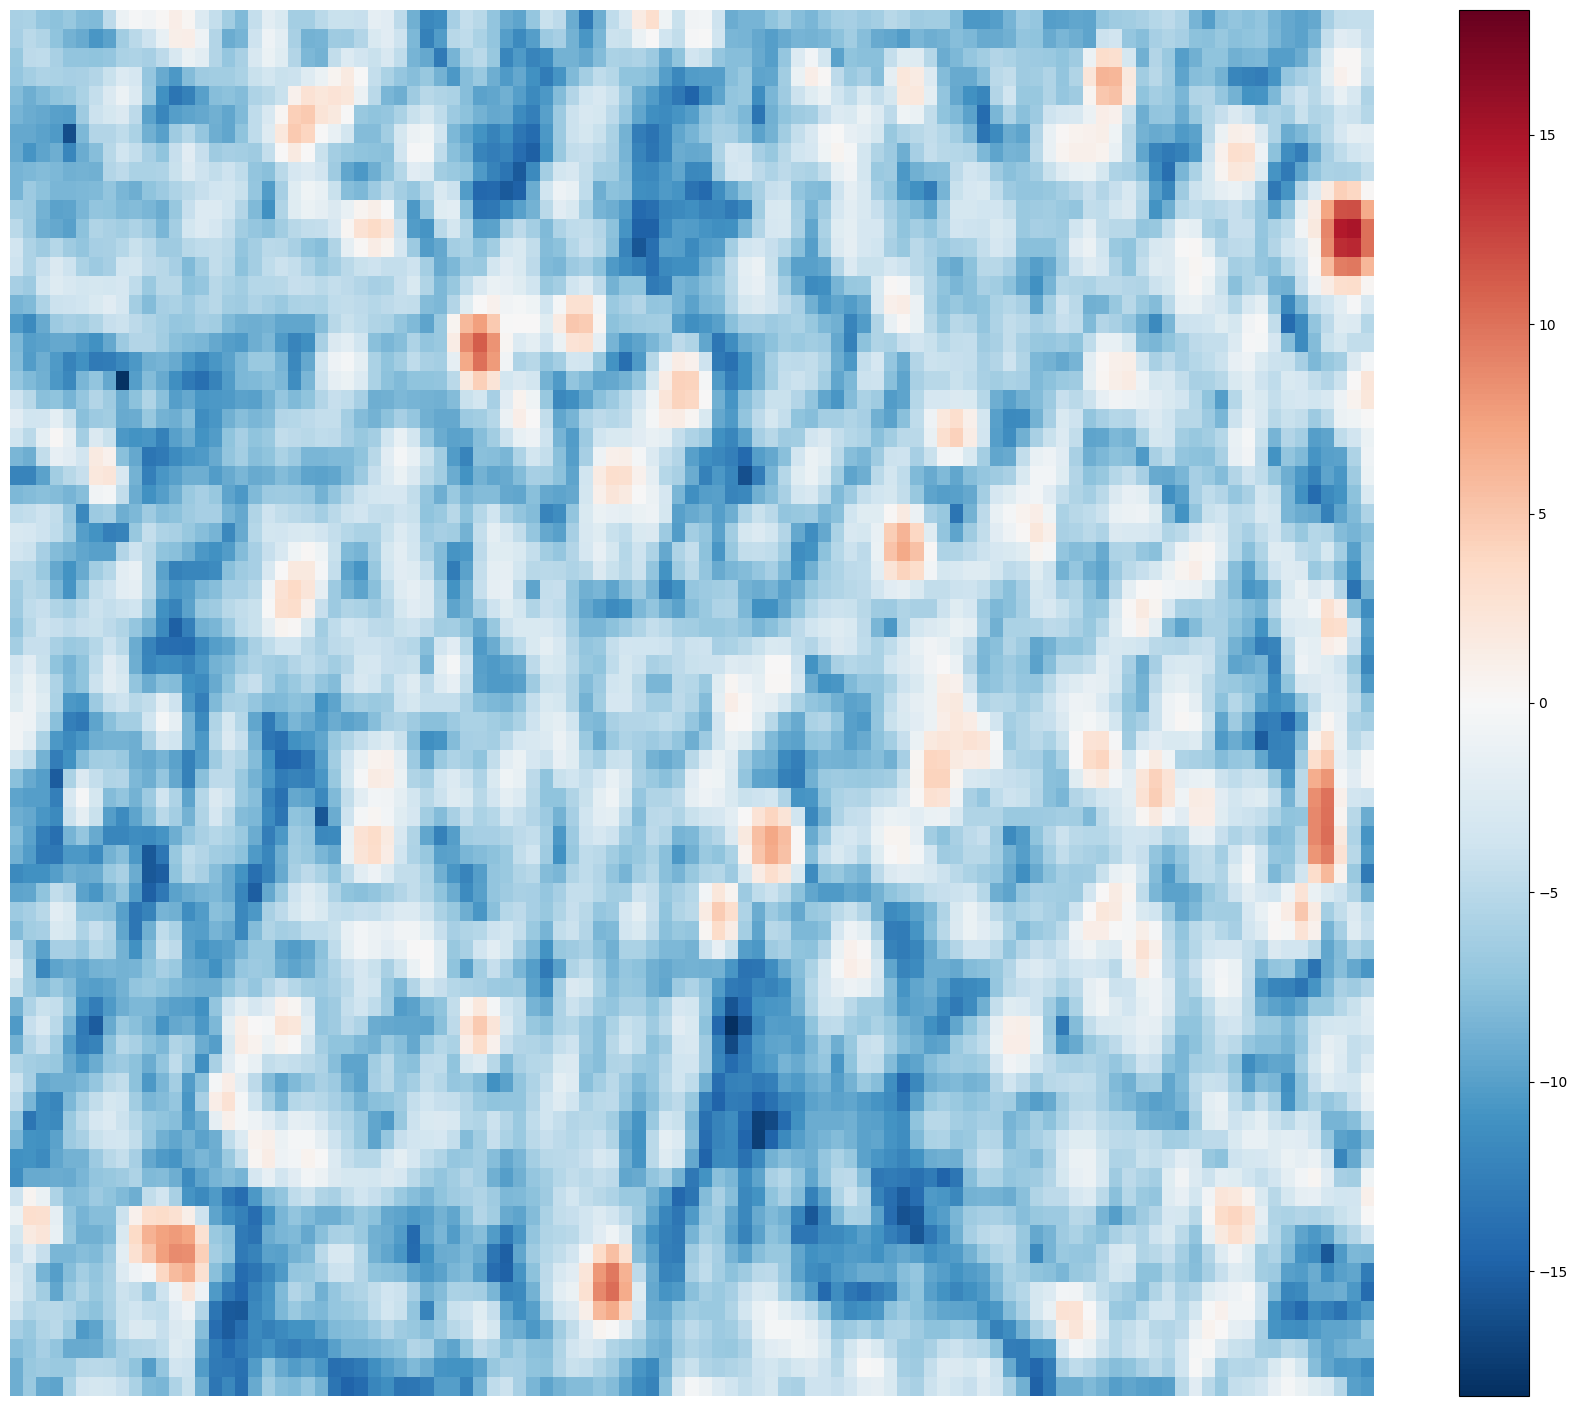

In [6]:
fig, ax = plt.subplots(figsize=(22, 18))
ax.set_axis_off()
# plot the data - single image
data[{"t":0,"bands": 0}].plot.imshow(ax=ax, add_labels=False)

plt.show()

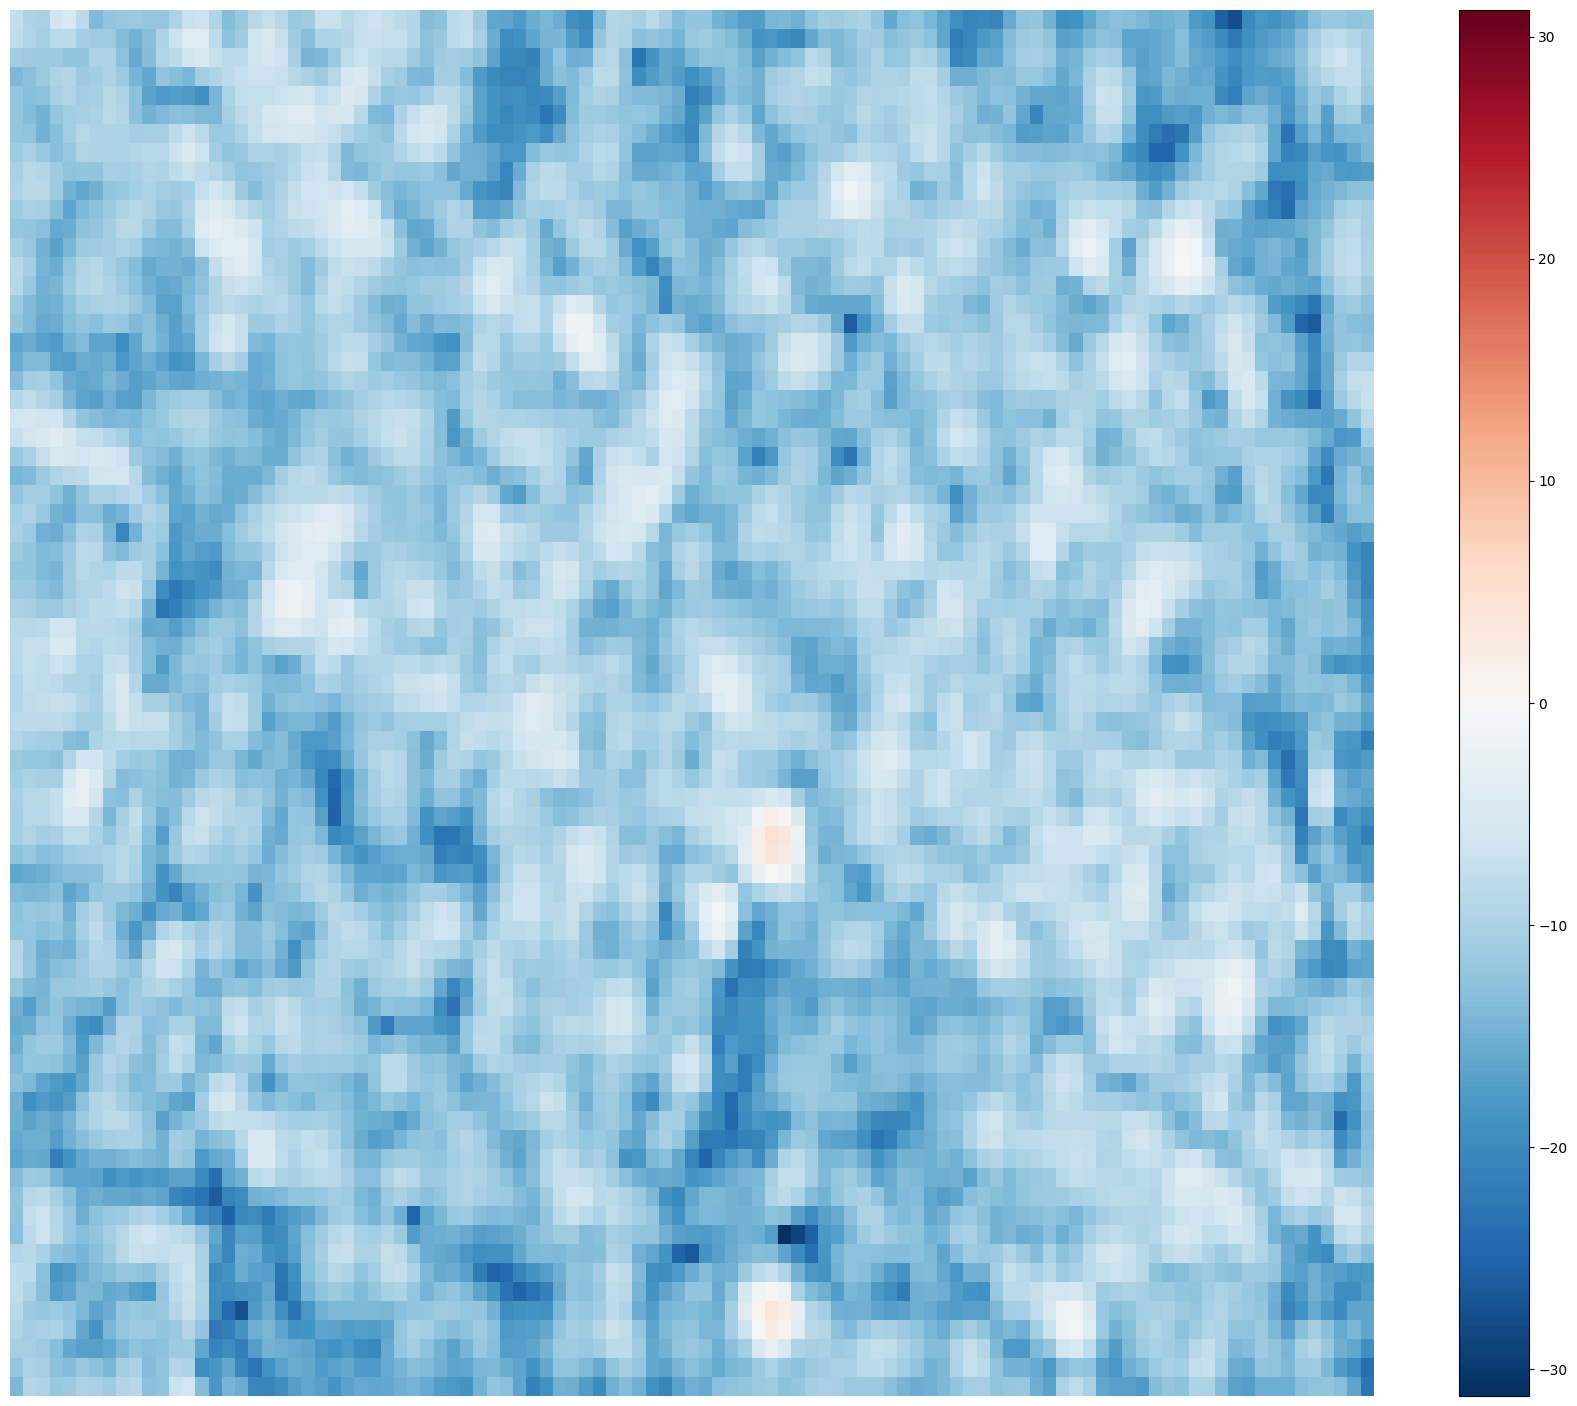

In [7]:
fig, ax = plt.subplots(figsize=(22, 18))
ax.set_axis_off()
# plot the data - single image
data[{"t": 0, "bands": 1}].plot.imshow(ax=ax, add_labels=False)

plt.show()

Get all frames into lists

In [8]:
threshold = 0.05

In [9]:
# Get all VVs
list_of_images = []
list_of_dates = []
list_of_used_indexes = []
for i in tqdm(range(data.shape[1])):  # data.shape[1]
    img = np.array(data[{"t": i, "bands": 0}])
    date = datetime.datetime.fromtimestamp(data["t"][i].item() / 10**9).strftime("%Y/%m/%d")
    if np.sum(np.isnan(img)) / (np.size(img))<threshold:
        # TODO What to do with Nans?
        # img = np.nan_to_num(img)
        mask = np.where(~np.isnan(img))
        interp = NearestNDInterpolator(np.transpose(mask), img[mask])
        filled_data = interp(*np.indices(img.shape))
        # Clip min max
        # img_clipped = np.clip(img, a_min=-125, a_max=125)
        # Convert to RGB int
        # img_clipped += 125
        # Crop to int
        # img_clipped = img_clipped.astype(np.uint8)
        list_of_images.append(filled_data)
        list_of_dates.append(date)
        list_of_used_indexes.append(i)
    else:
        print(f"Skipping frame {i} - {date}")

100%|██████████| 8/8 [00:00<00:00, 153.12it/s]


In [ ]:
np.savez(
    "mid_results.npz",
    list_of_images=list_of_images,
    list_of_dates=list_of_dates,
    list_of_used_indexes=list_of_used_indexes,
)

In [11]:
npz = np.load("mid_results.npz", allow_pickle=True)
list_of_images = npz["list_of_images"]
list_of_dates = npz["list_of_dates"]
list_of_used_indexes = npz["list_of_used_indexes"]
list_of_dates

array(['2021/01/02', '2021/01/04', '2021/01/08', '2021/01/10',
       '2021/01/14', '2021/01/16', '2021/01/22', '2021/01/26',
       '2021/01/28', '2021/02/01', '2021/02/03', '2021/02/07',
       '2021/02/09', '2021/02/13', '2021/02/15', '2021/02/19',
       '2021/02/21', '2021/02/25', '2021/02/27', '2021/03/03',
       '2021/03/05', '2021/03/09', '2021/03/11', '2021/03/15',
       '2021/03/17', '2021/03/21', '2021/03/23', '2021/03/27',
       '2021/03/29', '2021/04/02', '2021/04/04', '2021/04/08',
       '2021/04/10', '2021/04/14', '2021/04/16', '2021/04/20',
       '2021/04/22', '2021/04/26', '2021/04/28', '2021/05/02',
       '2021/05/04', '2021/05/08', '2021/05/10', '2021/05/14',
       '2021/05/16', '2021/05/20', '2021/05/22', '2021/05/26',
       '2021/05/28', '2021/06/01', '2021/06/03', '2021/06/07',
       '2021/06/09', '2021/06/13', '2021/06/15', '2021/06/19',
       '2021/06/21', '2021/06/25', '2021/06/27', '2021/07/01',
       '2021/07/03', '2021/07/07', '2021/07/09', '2021/

Convert all frames into video

In [10]:
images_arr = np.array(list_of_images)
img_max = np.max(np.array(images_arr))
img_min = np.min(np.array(images_arr))
cumulations_array = (images_arr + np.abs(img_min)) / (img_max - img_min)
cumulations_array = (cumulations_array * 255).astype(np.uint8)

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

image_list = []

for image, image_date, image_index in tqdm(zip(list_of_images, list_of_dates, list_of_used_indexes)):
    # Step 1: Create a figure with matplotlib
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(image, cmap="Spectral")
    ax.axis("off")
    ax.set_title(f"Image id {list_of_used_indexes}-{image_date}")

    # Step 2: Render the figure to a canvas
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Step 3: Convert the canvas to a NumPy array
    img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(canvas.get_width_height()[::-1] + (3,))  # Reshape to (height, width, 3)

    # Close the figure to free memory
    plt.close(fig)

    # Step 4: Store the array in a list
    image_list.append(img_array)

0it [00:00, ?it/s]/tmp/ipykernel_13527/4053252599.py:19: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
8it [00:00, 10.28it/s]


In [12]:
# Output video
output_file = "frame_depth.mp4"
height, width, layers = image_list[0].shape
fps = 2

video = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

for image in image_list:
    video.write(image)

video.release()
print(f"Video saved as {output_file}")

Video saved as frame_depth.mp4


In [13]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

image_list = []

for image_index, image_date in zip(list_of_used_indexes, list_of_dates):
    # Step 1: Create a figure with matplotlib
    fig, ax = plt.subplots(figsize=(20, 20))
    data[{"t": image_index, "bands": 0}].plot.imshow(ax=ax, add_labels=False)
    ax.axis("off")
    ax.set_title(f"Image id {image_index}-{image_date}")

    # Step 2: Render the figure to a canvas
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Step 3: Convert the canvas to a NumPy array
    img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(canvas.get_width_height()[::-1] + (3,))  # Reshape to (height, width, 3)

    # Close the figure to free memory
    plt.close(fig)

    # Step 4: Store the array in a list
    image_list.append(img_array)

/tmp/ipykernel_13527/258839472.py:19: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


In [14]:
# Output video
output_file = "frame_depth_with_bar.mp4"
height, width, layers = image_list[0].shape
fps = 2

video = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

for image in image_list:
    video.write(image)

video.release()
print(f"Video saved as {output_file}")

Video saved as frame_depth_with_bar.mp4


Calculate cumulative develpment

In [15]:
list_of_cumulations = []
previous_image = list_of_images[0]
change_array = np.zeros_like(previous_image)


for date, img in tqdm(zip(list_of_dates[1:], list_of_images[1:])):
    change_array += (img - previous_image)
    list_of_cumulations.append(change_array.copy())

7it [00:00, 21275.46it/s]


Visualize cumulative changes

In [16]:
cumulations_array = np.array(list_of_cumulations)
cum_max = np.max(np.array(list_of_cumulations))
cum_min = np.min(np.array(list_of_cumulations))
cumulations_array = (cumulations_array + np.abs(cum_min)) / (cum_max - cum_min)
cumulations_array = (cumulations_array * 255).astype(np.uint8)

In [17]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

image_list = []

for image_id, image in enumerate(cumulations_array):
    # Step 1: Create a figure with matplotlib
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(image, cmap="Spectral")
    ax.axis("off")
    ax.set_title(f"Image id {list_of_dates[image_id]}")

    # Step 2: Render the figure to a canvas
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Step 3: Convert the canvas to a NumPy array
    img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(canvas.get_width_height()[::-1] + (3,))  # Reshape to (height, width, 3)

    # Close the figure to free memory
    plt.close(fig)

    # Step 4: Store the array in a list
    image_list.append(img_array)

/tmp/ipykernel_13527/916704588.py:19: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


In [18]:
# Output video
output_file = "cumulative_changes.mp4"
height, width, layers = image_list[0].shape
fps = 2

video = cv2.VideoWriter(output_file, cv2.VideoWriter_fourcc(*"mp4v"), fps, (width, height))

for image in image_list:
    video.write(image)

video.release()
print(f"Video saved as {output_file}")

Video saved as cumulative_changes.mp4


Visualize for selected dates

list_of_images = npz["list_of_images"]
list_of_dates = npz["list_of_dates"]
list_of_used_indexes = npz["list_of_used_indexes"]

In [19]:
selected_dates = [
    "2022/12/23",
    "2023/01/28",
    "2023/02/09",
]

In [25]:
len(list_of_images)

8

In [26]:
dates_mask.shape

(8,)

In [29]:
dates_mask = np.isin(list_of_dates, selected_dates)

selected_images = np.array(list_of_images)[dates_mask]
selected_indexes = np.array(list_of_used_indexes)[dates_mask]

Selected depths

/tmp/ipykernel_13527/4243450354.py:19: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)


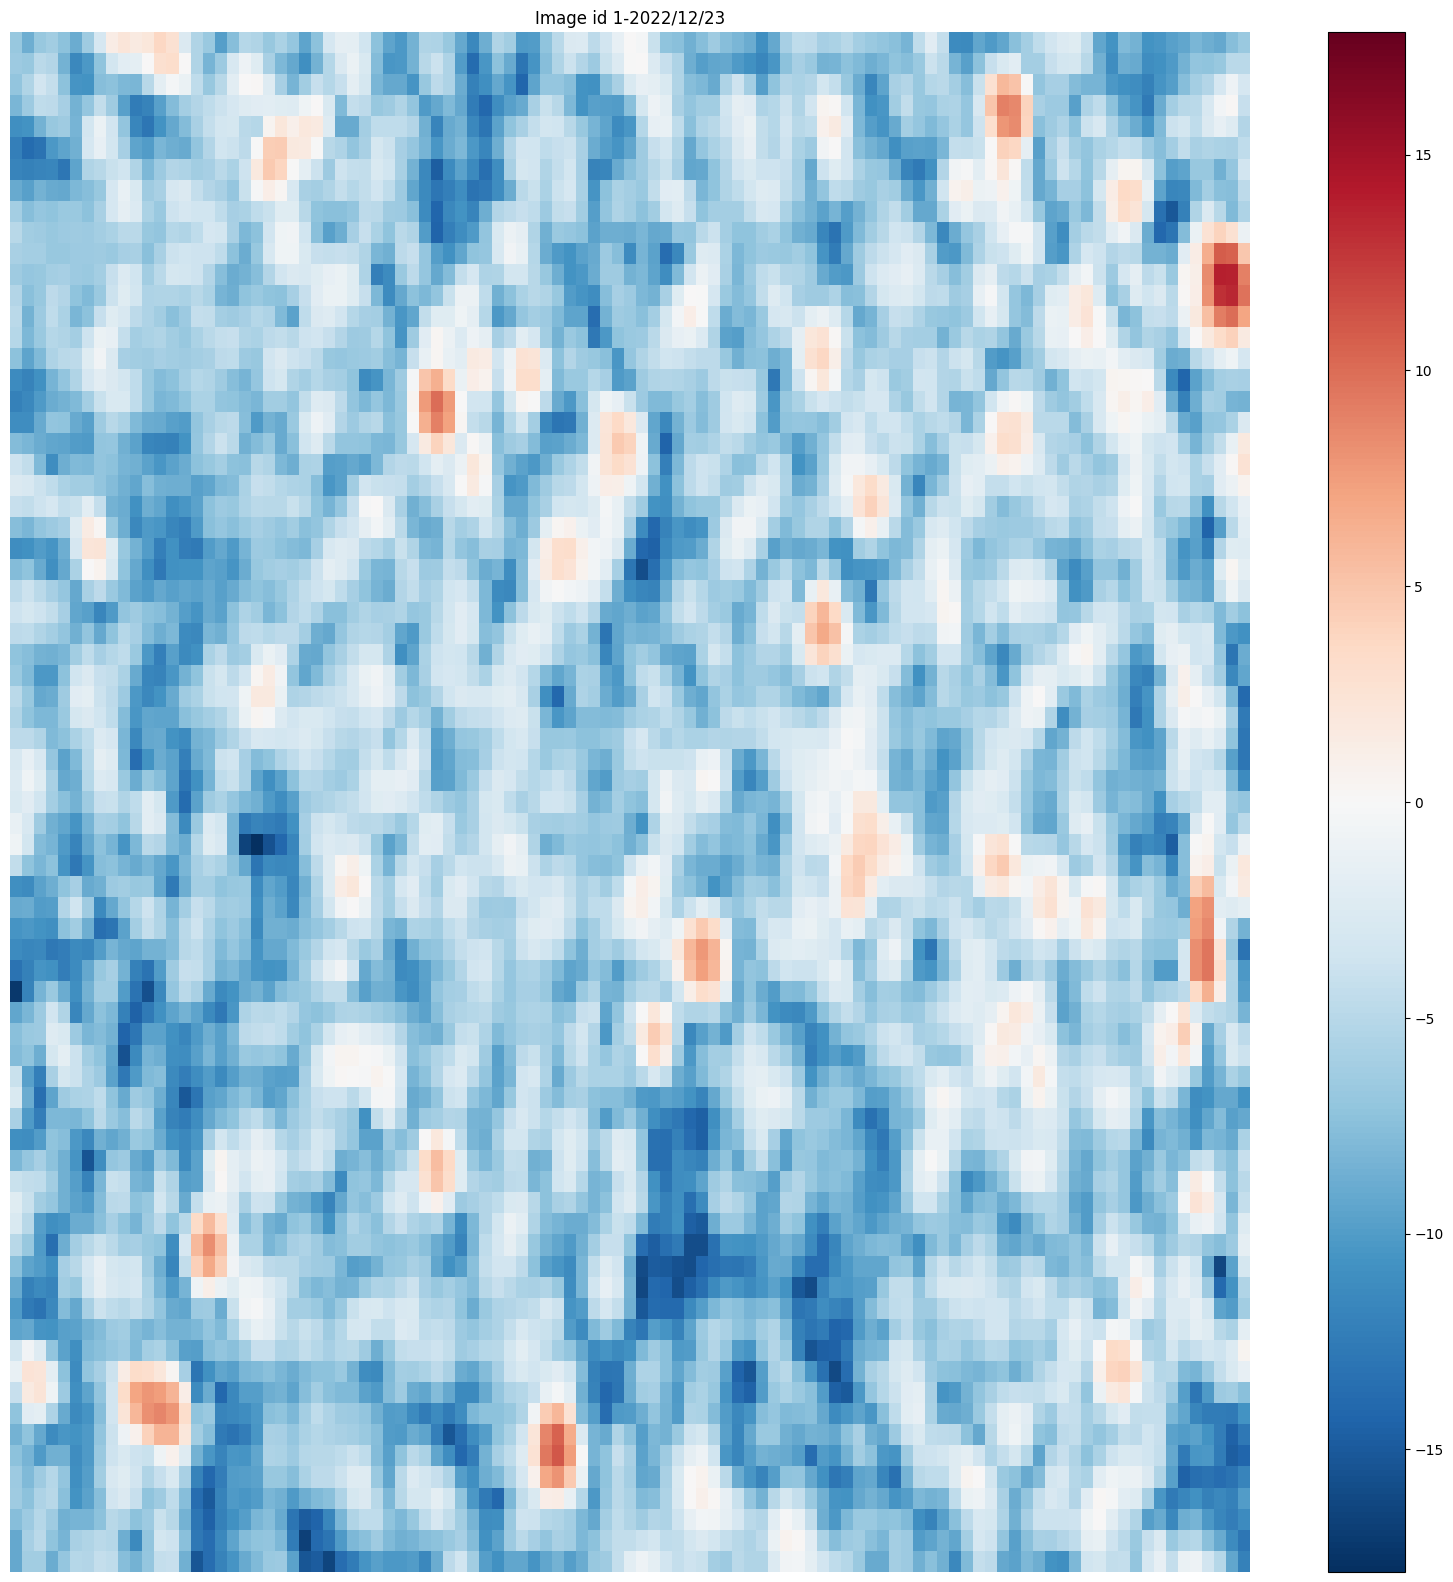

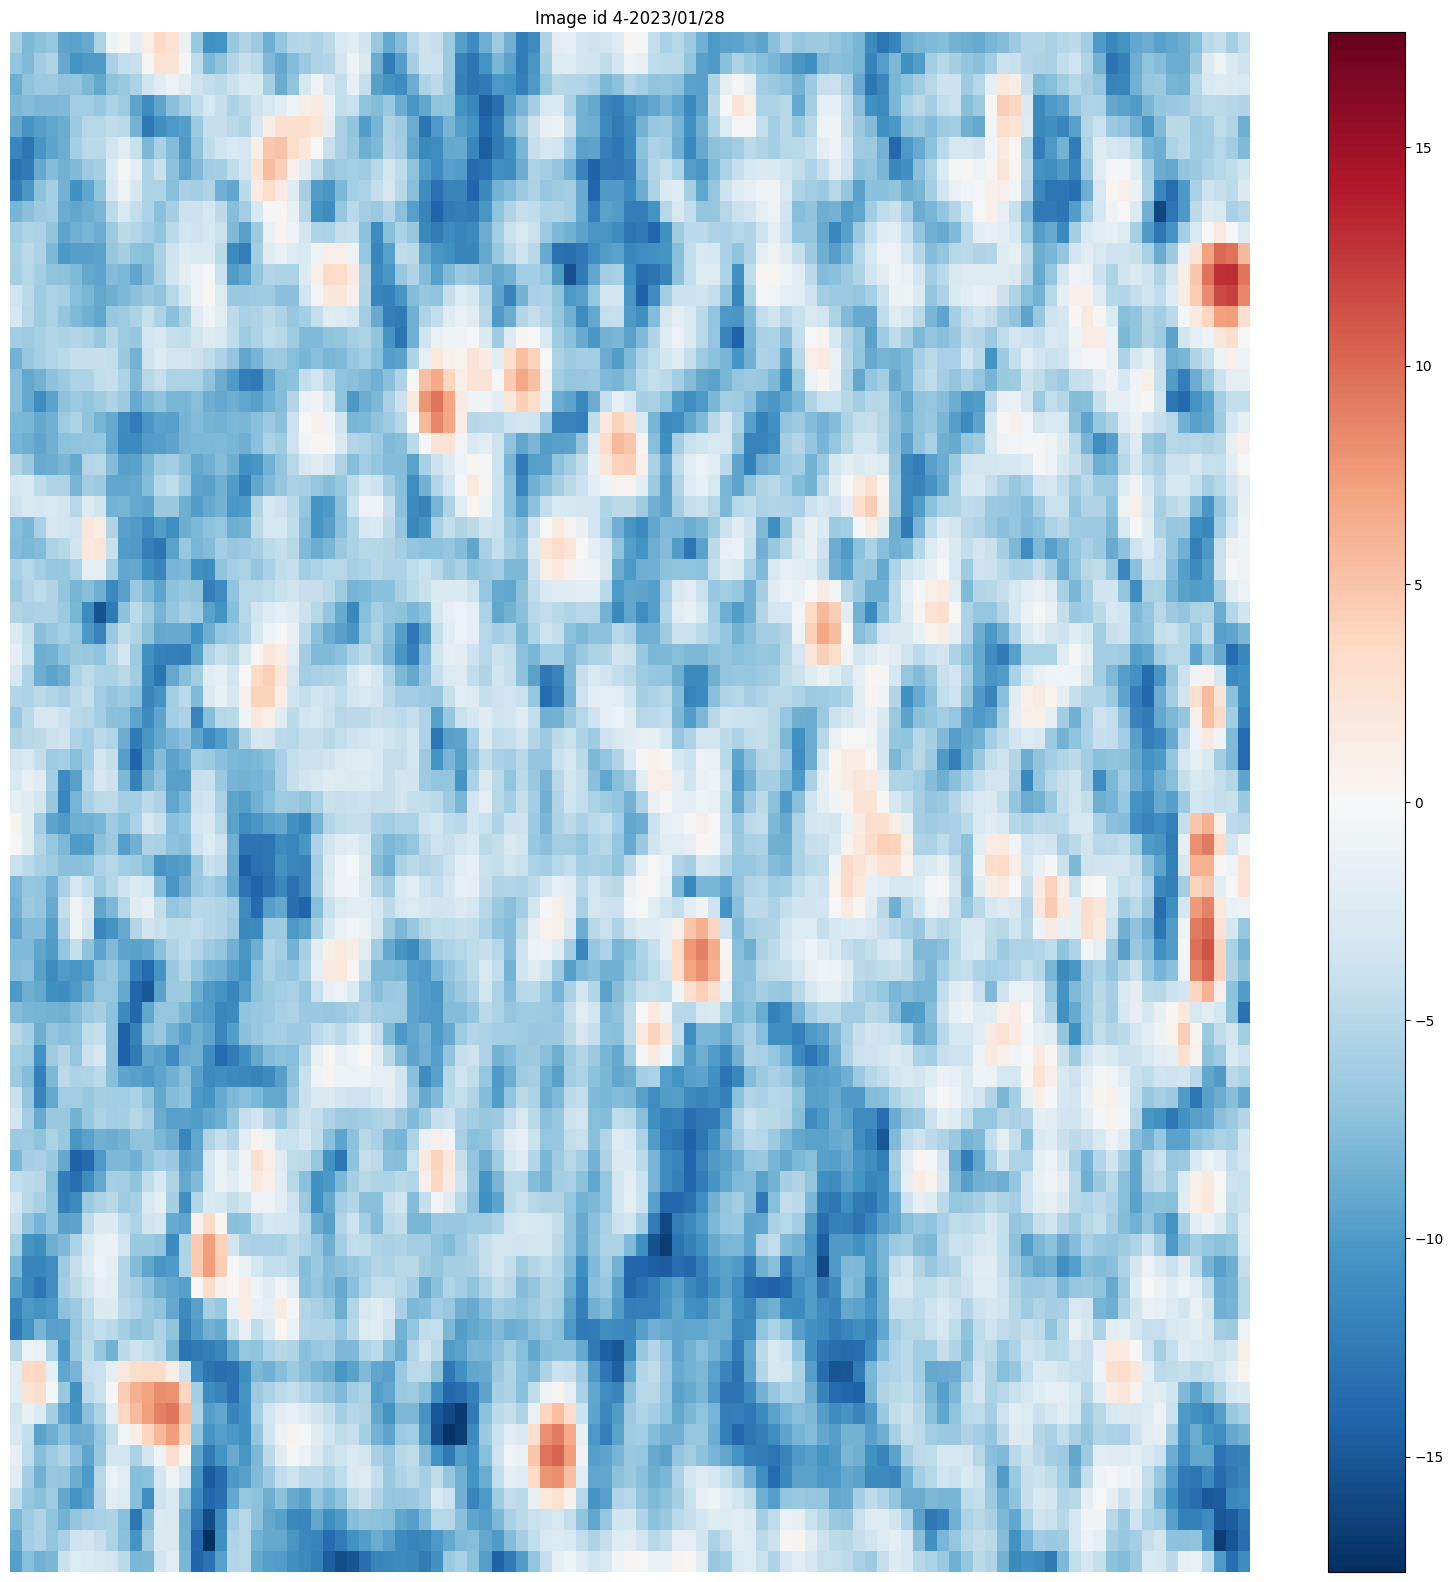

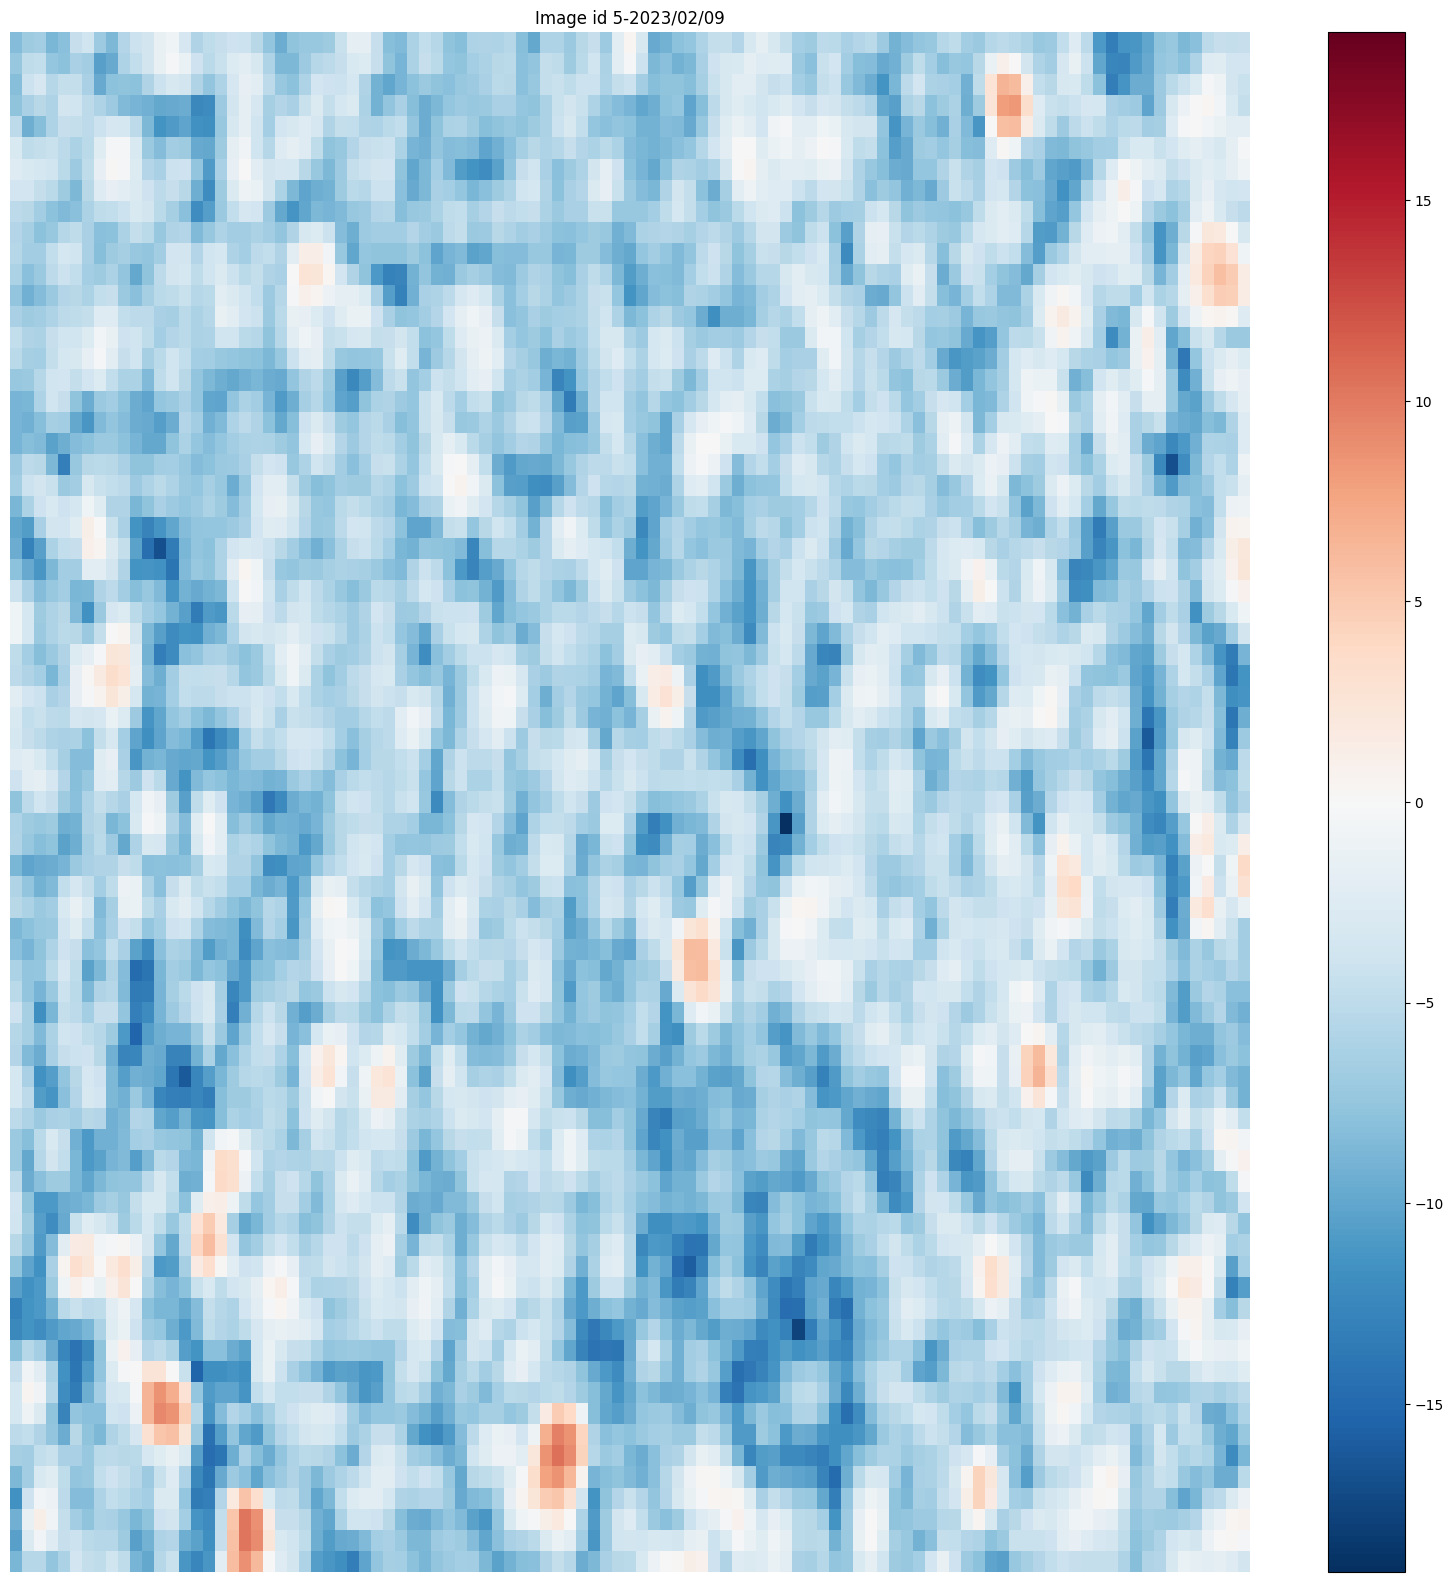

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

image_list = []

for image_index, image_date in zip(selected_indexes, selected_dates):
    # Step 1: Create a figure with matplotlib
    fig, ax = plt.subplots(figsize=(20, 20))
    data[{"t": image_index, "bands": 0}].plot.imshow(ax=ax, add_labels=False)
    ax.axis("off")
    ax.set_title(f"Image id {image_index}-{image_date}")

    # Step 2: Render the figure to a canvas
    canvas = FigureCanvas(fig)
    canvas.draw()

    # Step 3: Convert the canvas to a NumPy array
    img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(canvas.get_width_height()[::-1] + (3,))  # Reshape to (height, width, 3)

    # Close the figure to free memory
    plt.show()
    #plt.close(fig)

    # Step 4: Store the array in a list
    image_list.append(img_array)

Selected deltas

In [31]:
previsous_frame = selected_images[0]
change_arr = np.zeros_like(previsous_frame)
list_of_changes = []

for image in selected_images[1:]:
    change_arr += image - previsous_frame
    list_of_changes.append(change_arr.copy())

In [32]:
changes_arr = np.array(list_of_changes)
change_max = np.max(changes_arr)
change_min = np.min(changes_arr)
changes_arr = (((changes_arr + np.abs(change_min))/(change_max-change_min))*255).astype(np.uint8)

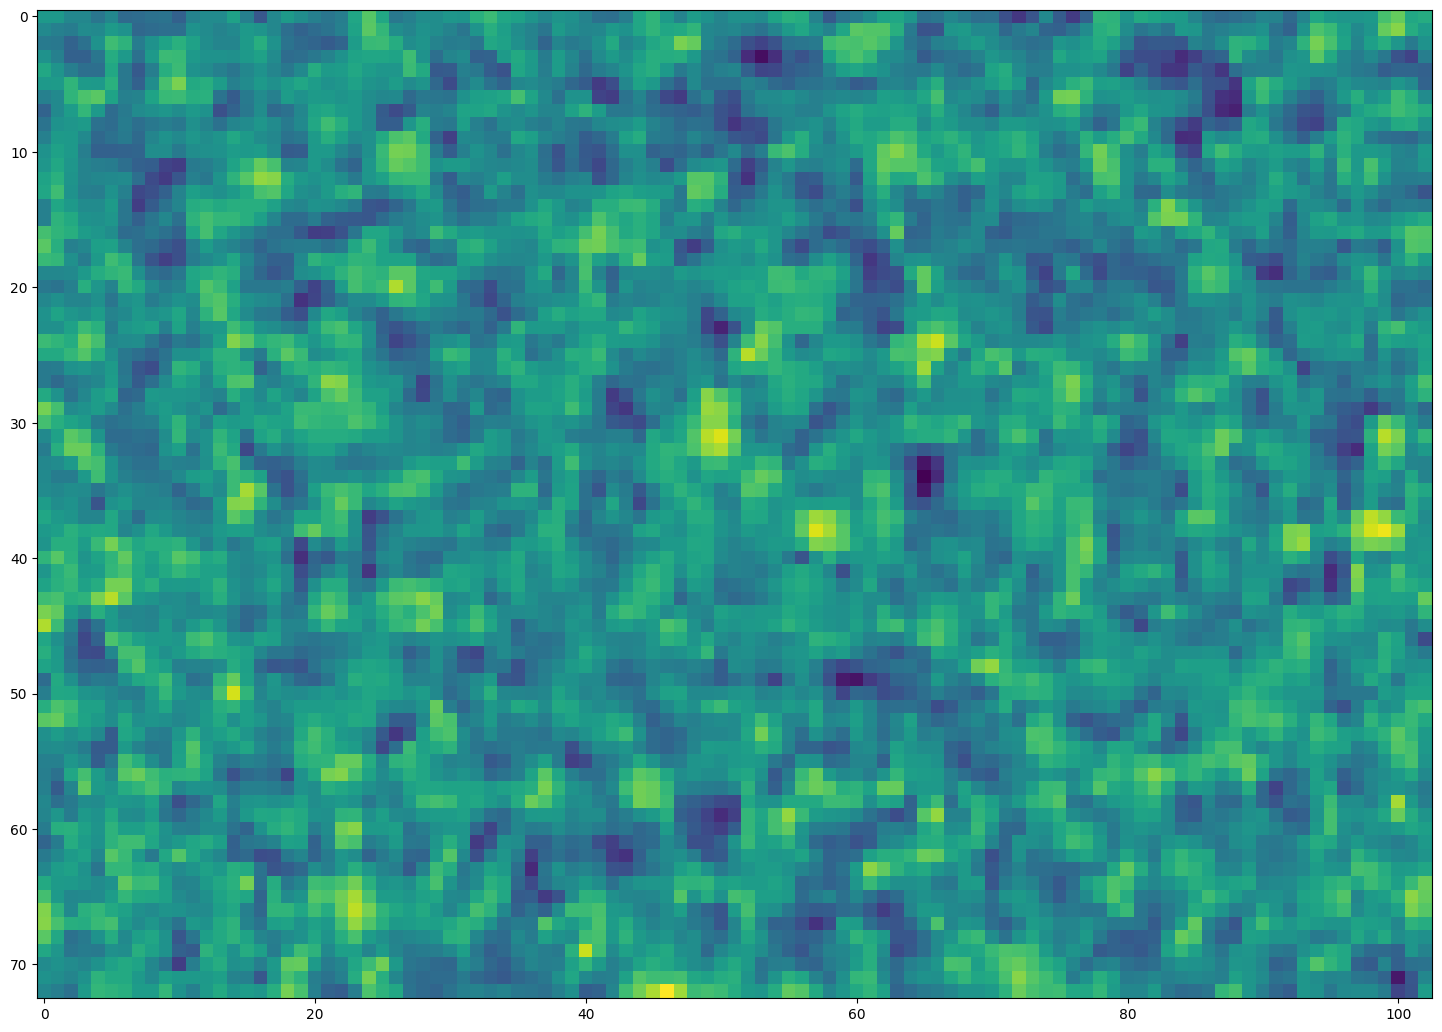

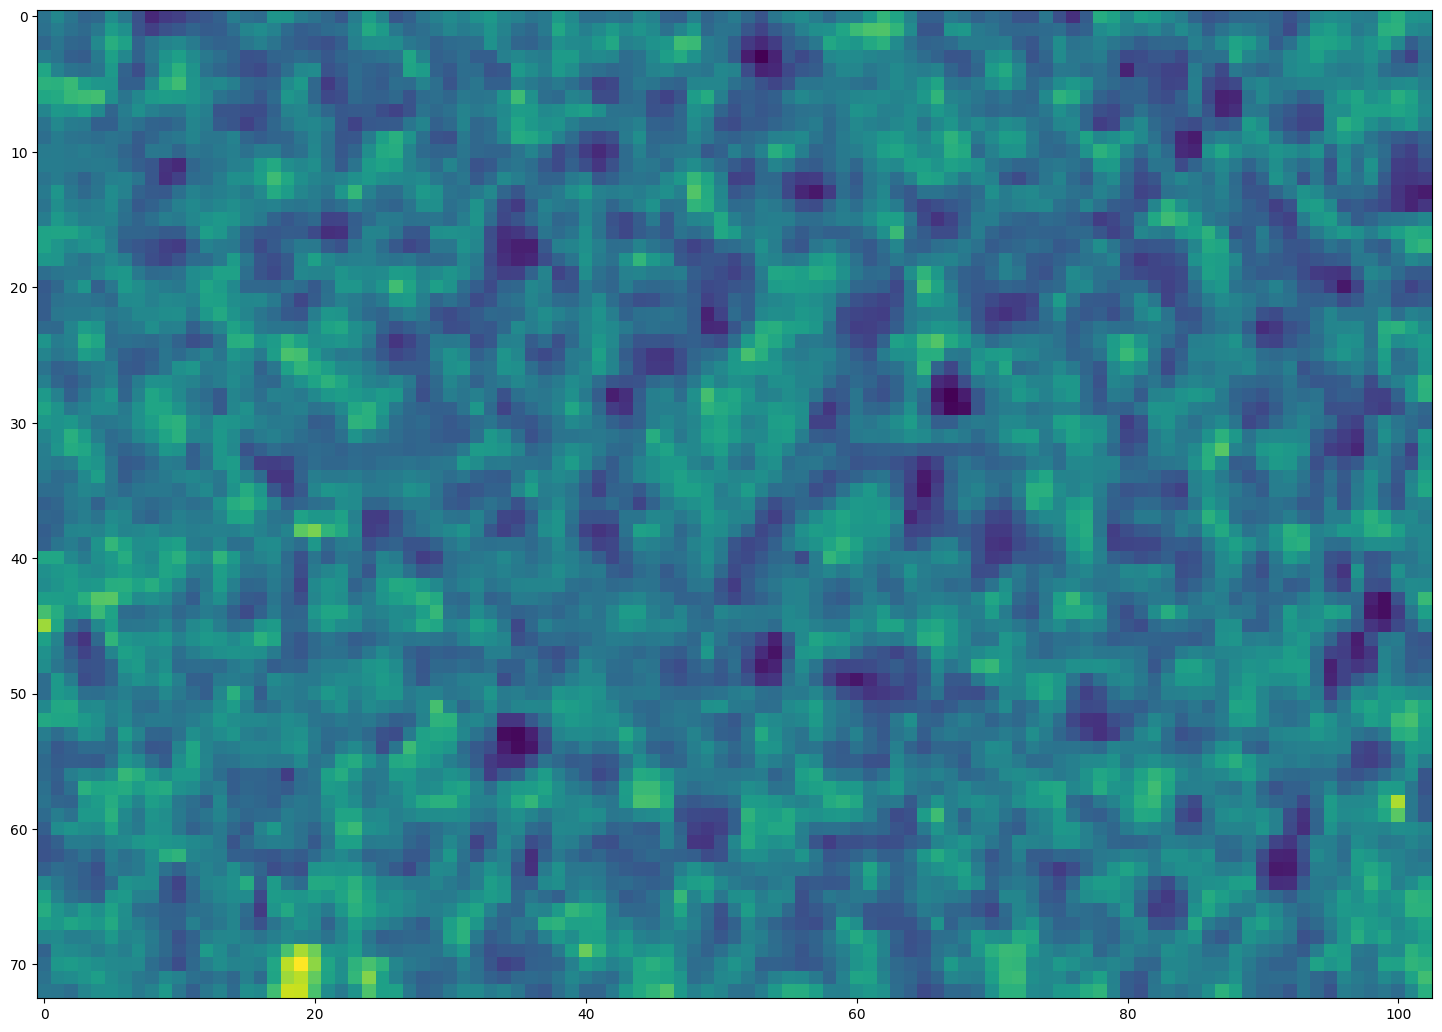

In [33]:
for change in changes_arr:
    plt.figure(figsize=(18,18))
    plt.imshow(change)
    plt.show()

In [34]:
change_arr += image - selected_images[0]

In [35]:
changes_arr = np.array(list_of_changes)
change_max = np.max(changes_arr)
change_min = np.min(changes_arr)
changes_arr = (((changes_arr + np.abs(change_min)) / (change_max - change_min)) * 255).astype(np.uint8)

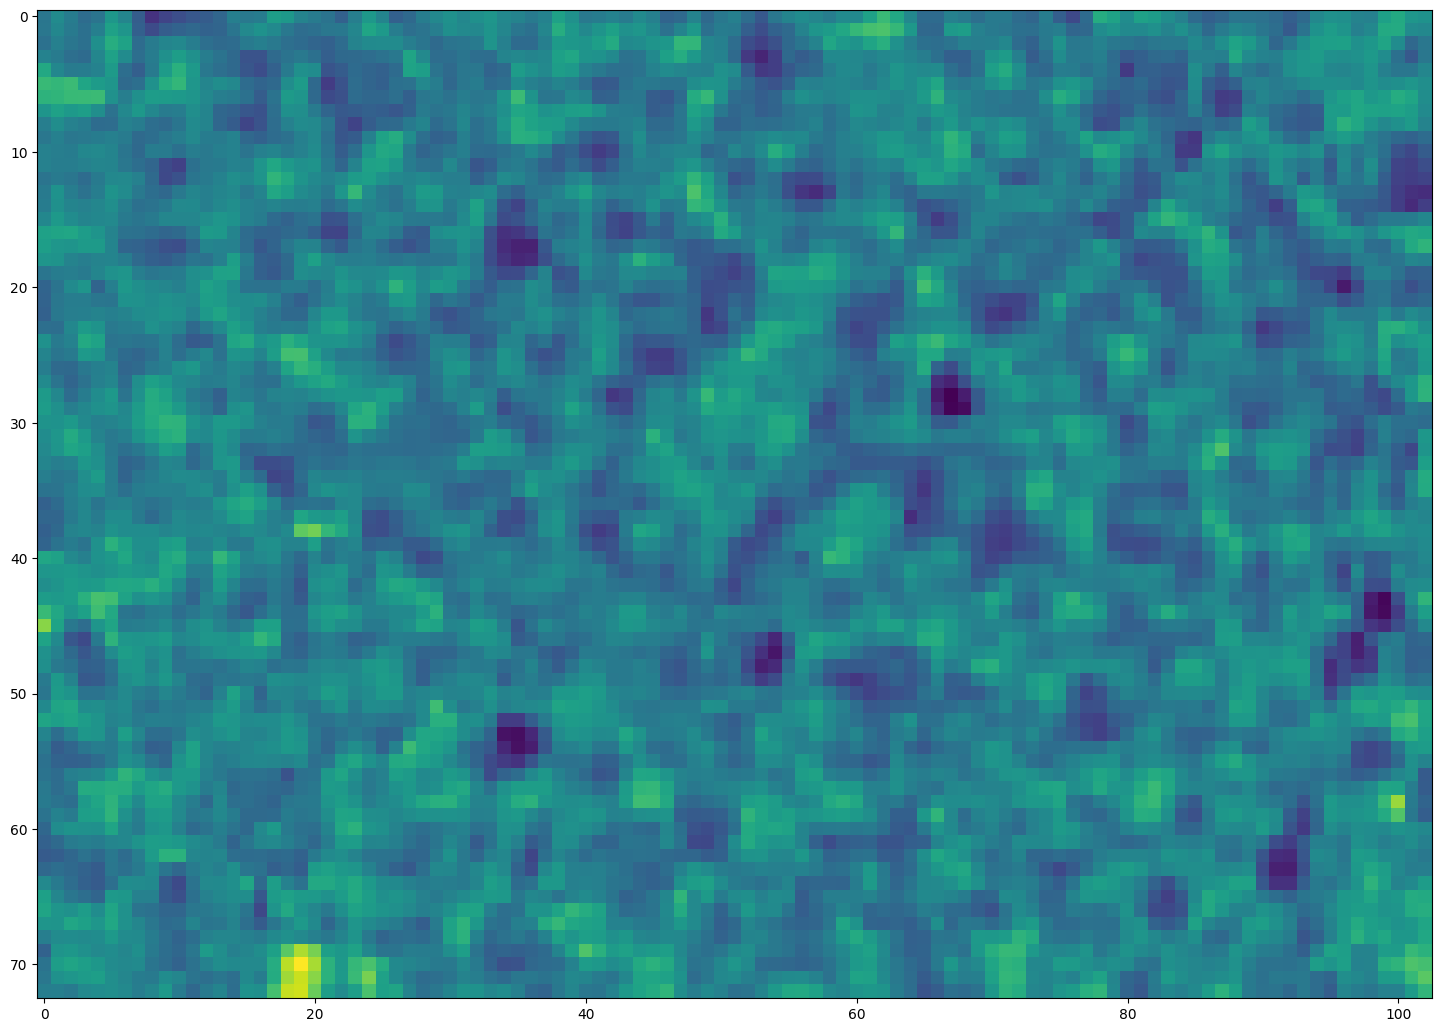

In [36]:
plt.figure(figsize=(18,18))
plt.imshow(change_arr)
plt.show()

Save json

In [42]:
output_dict = []

for date, image in zip(selected_dates, selected_images):
    for y_id, row in enumerate(image):
        for x_id, cell in enumerate(row):
            output_dict.append({"date": date, "x": x_id, "y": y_id, "z":cell})

In [40]:
selected_images[0].shape

(73, 103)

In [43]:
import json
with open("sample.json", "w") as outfile:
    json.dump(output_dict, outfile)